In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
### Apply function to values in nested dictionary

def apply_recursive(obj, func):
    if isinstance(obj, dict):  # if dict, apply to each key
        return {k: apply_recursive(v, func) for k, v in obj.items()}
    elif isinstance(obj, list):  # if list, apply to each element
        return [apply_recursive(elem, func) for elem in obj]
    else:
        return func(obj)

def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict, level=-1):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    # df = df.unstack(level=level)
    # df.columns = df.columns.map("{0[1]}".format)
    return df

def load_to_multi_index(path):
    results_dict = np.load(path, allow_pickle=True)
    fixed_results_dict = results_dict # apply_recursive(results_dict, lambda df: df.iloc[0].to_dict())
    df = nested_dict_to_df(fixed_results_dict)
    df.index.names = ['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric']
    df.columns = ['Result']
    return df

# debug
# results_dict['UWAVE']['infogain']['resNet']['average']['normalized']['normal_distribution']


def load_from_folder(path):
    filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
    df_list = []
    for filename in filenames:
        filepath = os.path.join(path, filename)
        df = load_to_multi_index(path=filepath)
        df_list.append(df)
    merged_df = pd.concat(df_list)
    return merged_df


In [3]:
cwd = os.getcwd()
path = os.path.join(cwd, "data")
df_first = load_from_folder(path=path)
df_first.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb             Metric             
EOG     clasp        miniRocket sampling   normalized    normal_distribution AUCSE_top  0.428671
                                                                             F_score    0.236797
                                                         zeros               AUCSE_top  0.414165
                                                                             F_score    0.231345
                                                         global_mean         AUCSE_top  0.414533

In [4]:
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results")
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df_second = merged_df.set_index(['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric'])
df_second.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb Metric                  
EOG     clasp        miniRocket average    default       default AUC_difference  0.035630
                                           normalized    default AUC_difference  0.036960
                                zero       default       default AUC_difference  0.022017
                                           normalized    default AUC_difference  0.024911
                                sampling   default       default AUC_difference  0.031429

In [5]:
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "entropy_results")
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df_third = merged_df.set_index(['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric'])
df_third.head()

Result
Dataset Segmentation   ML model Background Normalization Perturb Metric           
EOG     clasp          resNet   average    default       mean    entropy  0.704625
                                                         std     entropy  0.235510
        greedygaussian resNet   average    default       mean    entropy  0.908797
                                                         std     entropy  0.056299
        equal          resNet   average    default       mean    entropy  1.000000

In [6]:
df = pd.concat([df_first, df_second, df_third]).reset_index()

In [7]:
df

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result
0,EOG,clasp,miniRocket,sampling,normalized,normal_distribution,AUCSE_top,0.428671
1,EOG,clasp,miniRocket,sampling,normalized,normal_distribution,F_score,0.236797
2,EOG,clasp,miniRocket,sampling,normalized,zeros,AUCSE_top,0.414165
3,EOG,clasp,miniRocket,sampling,normalized,zeros,F_score,0.231345
4,EOG,clasp,miniRocket,sampling,normalized,global_mean,AUCSE_top,0.414533
...,...,...,...,...,...,...,...,...
7845,UWAVE,equal,resNet,average,default,std,entropy,0.000000
7846,UWAVE,infogain,resNet,average,default,mean,entropy,0.898486
7847,UWAVE,infogain,resNet,average,default,std,entropy,0.073749
7848,UWAVE,nnsegment,resNet,average,default,mean,entropy,0.966025


## Index and column names

In [8]:
df.index

RangeIndex(start=0, stop=7850, step=1)

In [9]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

## Masking

In [10]:
mask = (df["Metric"] == 'F_score') & (df["Result"] < 0)
df.loc[mask]

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result
4063,KeplerLightCurves,infogain,resNet,sampling,default,local_mean,F_score,-0.175967
4303,KeplerLightCurves,greedygaussian,resNet,zero,default,local_mean,F_score,-0.040177
4305,KeplerLightCurves,greedygaussian,resNet,zero,default,global_gaussian,F_score,-0.047075
4307,KeplerLightCurves,greedygaussian,resNet,zero,default,local_gaussian,F_score,-0.193623


In [11]:
mask = (df["Metric"] == 'AUC_difference') & (df["Dataset"] == 'KeplerLightCurves') & (df["ML model"] == 'miniRocket')
df.loc[mask]

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result
7260,KeplerLightCurves,clasp,miniRocket,average,default,default,AUC_difference,-0.001029
7261,KeplerLightCurves,clasp,miniRocket,average,normalized,default,AUC_difference,0.000411
7262,KeplerLightCurves,clasp,miniRocket,zero,default,default,AUC_difference,0.001844
7263,KeplerLightCurves,clasp,miniRocket,zero,normalized,default,AUC_difference,0.003142
7264,KeplerLightCurves,clasp,miniRocket,sampling,default,default,AUC_difference,0.004707
7265,KeplerLightCurves,clasp,miniRocket,sampling,normalized,default,AUC_difference,0.010993
7266,KeplerLightCurves,greedygaussian,miniRocket,average,default,default,AUC_difference,-0.001513
7267,KeplerLightCurves,greedygaussian,miniRocket,average,normalized,default,AUC_difference,0.000324
7268,KeplerLightCurves,greedygaussian,miniRocket,zero,default,default,AUC_difference,0.001764
7269,KeplerLightCurves,greedygaussian,miniRocket,zero,normalized,default,AUC_difference,0.002478


In [12]:
mask = (df["Metric"] == 'AUCSE_top') & (df["Result"] < 0)
df.loc[mask]

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result


In [13]:
mask = (df["Metric"] == 'AUC_difference') & (df["Result"].isna())
df.loc[mask].head()

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result


# Data Analysis

## Correlation matrix

In [14]:
mask = (df["Metric"]=='AUCSE_top')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

Perturb,global_gaussian,global_mean,local_gaussian,local_mean,normal_distribution,zeros
Perturb,,,,,,
global_gaussian,1.00,0.67,0.96,0.75,0.78,0.67
global_mean,0.67,1.00,0.66,0.76,0.48,1.00
local_gaussian,0.96,0.66,1.00,0.80,0.75,0.66
local_mean,0.75,0.76,0.80,1.00,0.53,0.77
normal_distribution,0.78,0.48,0.75,0.53,1.00,0.48
zeros,0.67,1.00,0.66,0.77,0.48,1.00


In [15]:
mask = (df["Metric"]=='F_score')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

Perturb,global_gaussian,global_mean,local_gaussian,local_mean,normal_distribution,zeros
Perturb,,,,,,
global_gaussian,1.00,0.08,0.55,0.08,0.20,0.08
global_mean,0.08,1.00,0.27,0.66,0.66,1.00
local_gaussian,0.55,0.27,1.00,0.21,0.45,0.27
local_mean,0.08,0.66,0.21,1.00,0.51,0.66
normal_distribution,0.20,0.66,0.45,0.51,1.00,0.65
zeros,0.08,1.00,0.27,0.66,0.65,1.00


In [16]:
# df2 = df.unstack(["Metric"])
# df2.columns = df2.columns.droplevel(0)
# corr = df2.corr()
# coef_det = corr ** 2
# coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

### AUCSE_top
#### local_mean vs global_mean

In [17]:
columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")

C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\201123492.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\201123492.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\201123492.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\201123492.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppDa

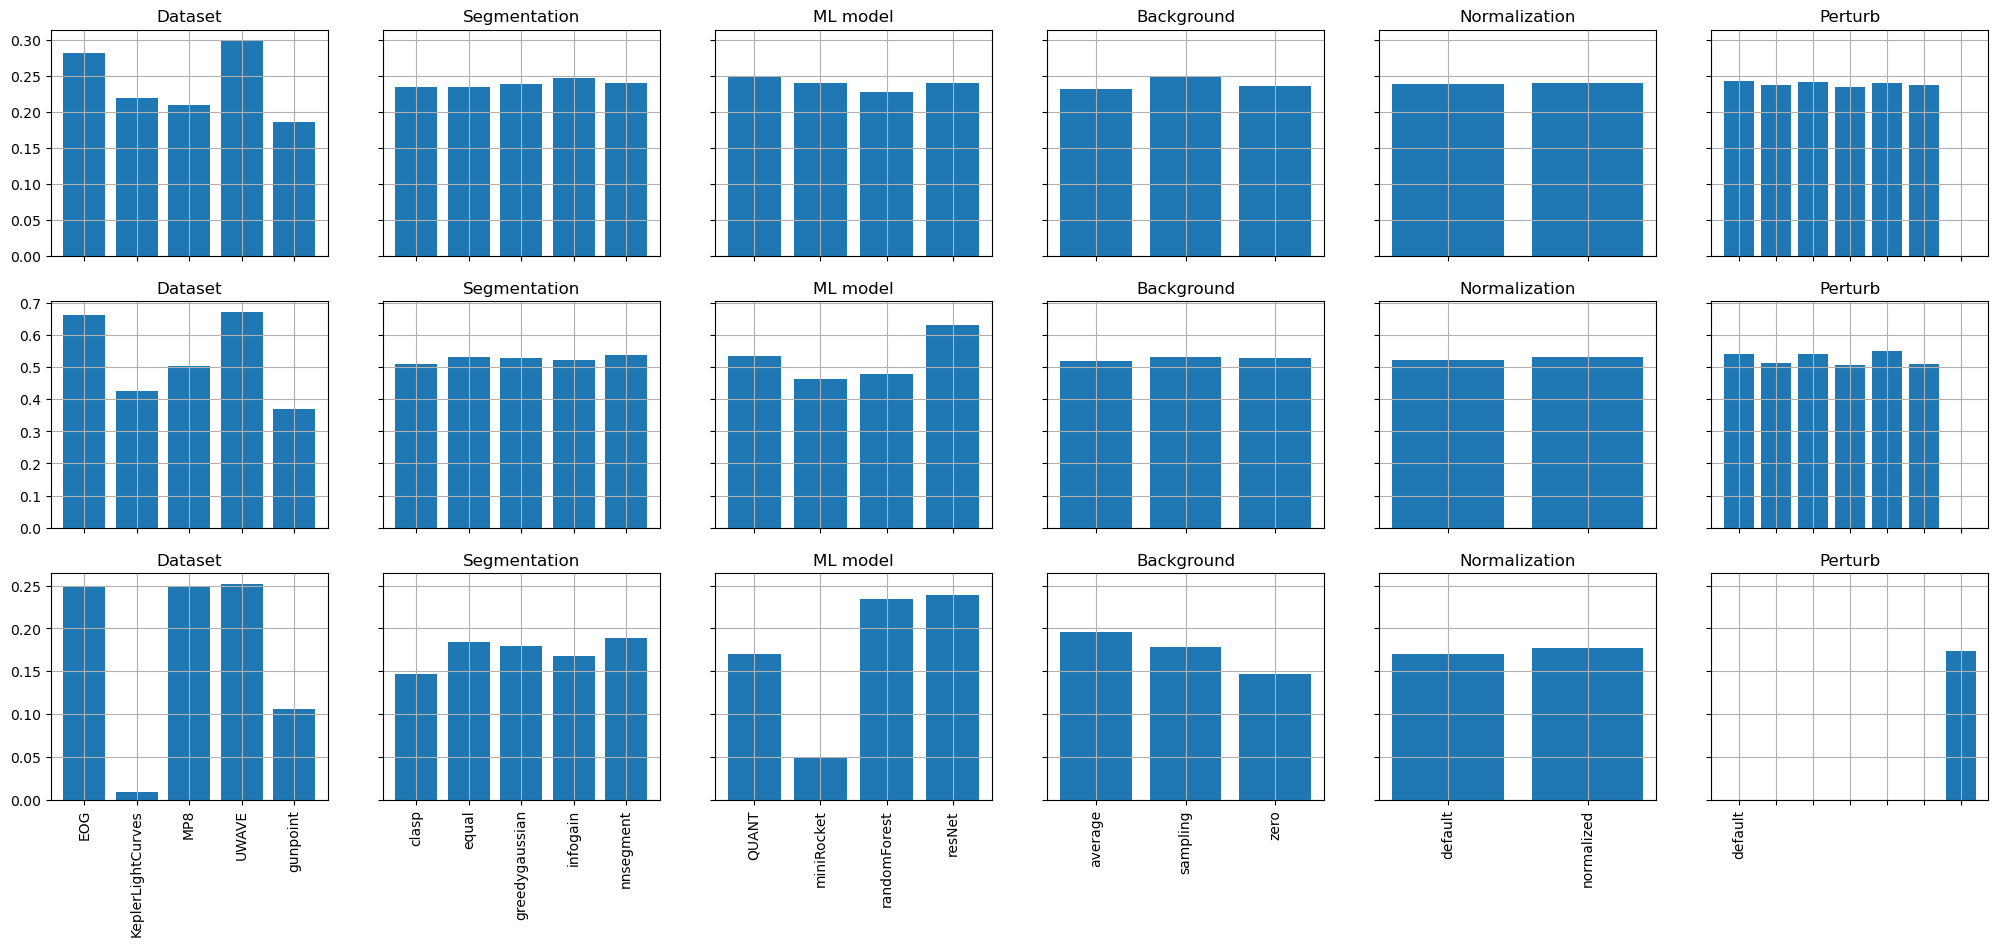

In [20]:
active_columns = columns_wo_result[:]
active_columns.remove("Metric")
metric_names = ['F_score', 'AUCSE_top', 'AUC_difference']

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (25,10), sharex="col", sharey="row")

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    #ax[j].set_title(metric_name)

    for i, column_name in enumerate(active_columns):
        new_index = columns_wo_result[:]
        new_index.remove(column_name)
        df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
        df3 = df3.mean()
        
        ax[j, i].grid()
        ax[j, i].bar(df3.index, df3)
        ax[j, i].set_xticklabels(df3.index, rotation=90)
        ax[j, i].set_title(column_name)

C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\492260750.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\492260750.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\492260750.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppData\Local\Temp\ipykernel_9876\492260750.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j, i].set_xticklabels(df3.index, rotation=90)
C:\Users\Nikos\AppDa

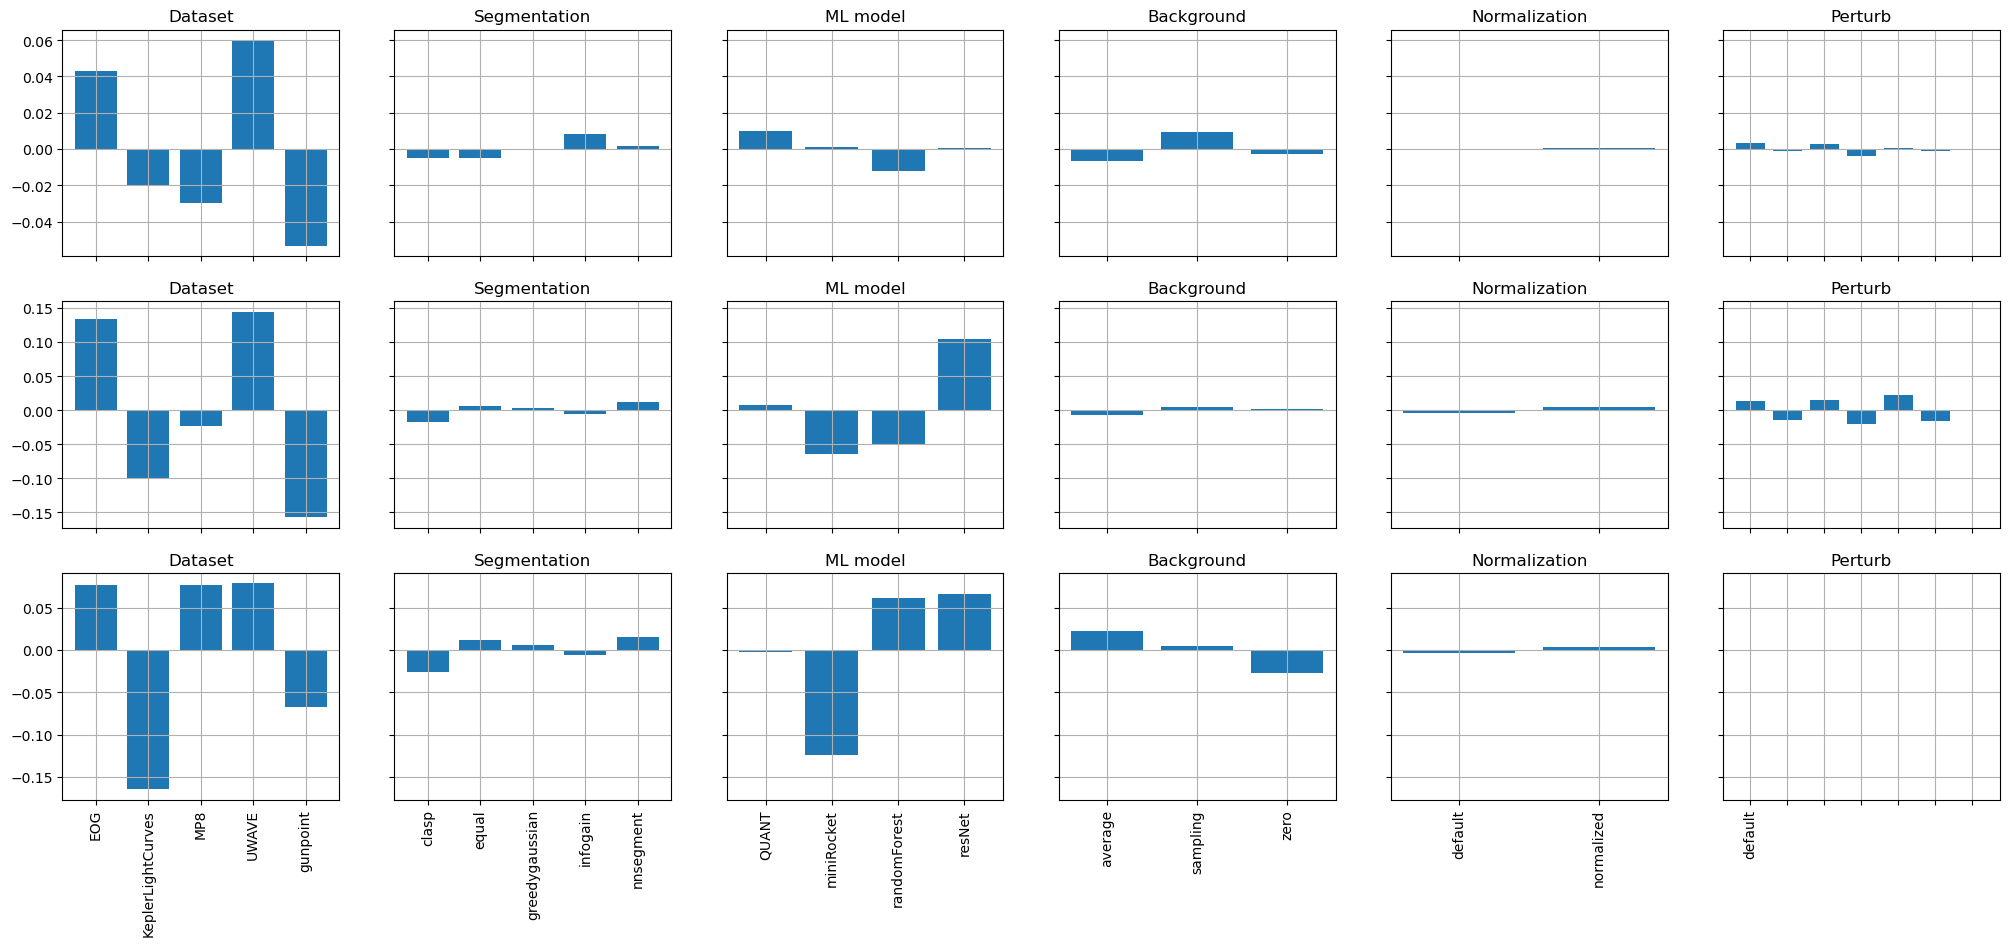

In [21]:
active_columns = columns_wo_result[:]
active_columns.remove("Metric")
metric_names = ['F_score', 'AUCSE_top', 'AUC_difference']

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (25,10), sharex="col", sharey="row")

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    #ax[j].set_title(metric_name)

    for i, column_name in enumerate(active_columns):
        new_index = columns_wo_result[:]
        new_index.remove(column_name)
        df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
        df3 = df3.mean()
        df3 = df3 - df3.mean() 
        
        ax[j, i].grid()
        ax[j, i].bar(df3.index, df3)
        ax[j, i].set_xticklabels(df3.index, rotation=90)
        ax[j, i].set_title(column_name)

In [ ]:
# entropy analysis

In [23]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

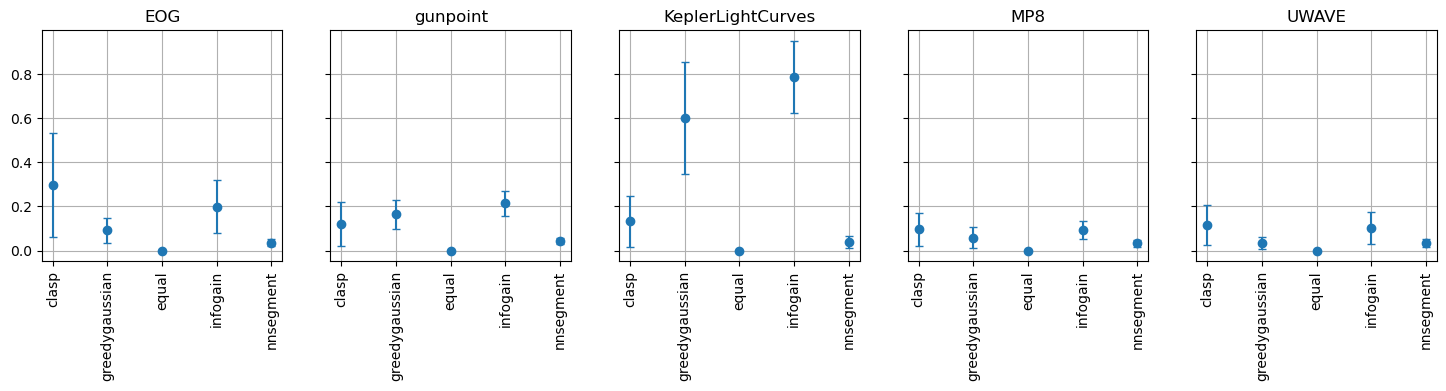

In [68]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="entropy")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (18,3), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="mean")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = 1-df4["Result"].values

    mask = (df3["Perturb"]=="std")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    e = df5["Result"].values

    ax[i].errorbar(x, y, e, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=90)

    

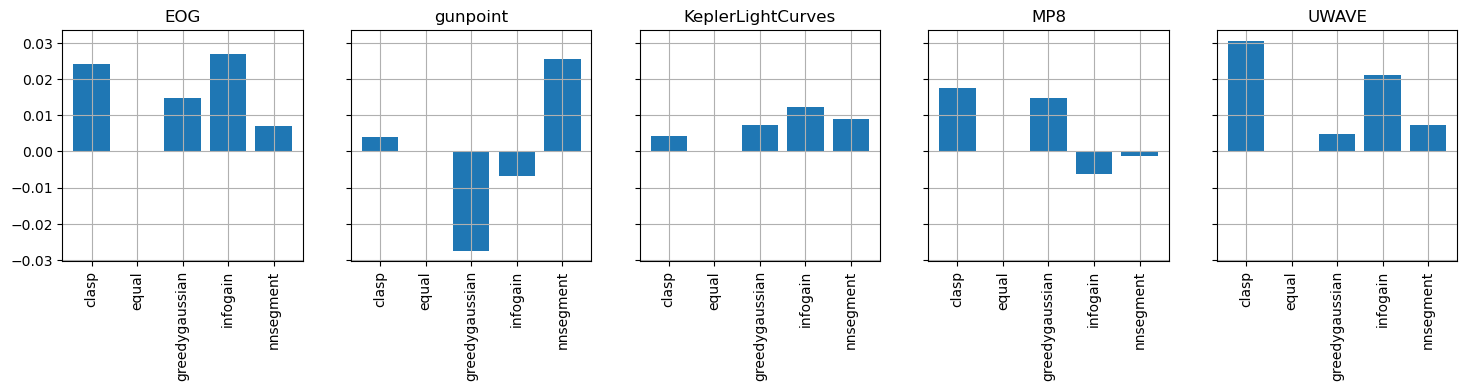

In [67]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="AUC_difference") # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask].groupby(["Dataset", "Segmentation", "Normalization"]).agg({'Result': "mean"}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (18,3), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Normalization", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Normalization"]=="default")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y1 = df4["Result"].values

    mask = (df3["Normalization"]=="normalized")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    y2 = df5["Result"].values

    ax[i].bar(x, y2-y1)
    ax[i].grid()
    ax[i].tick_params("x", rotation=90)

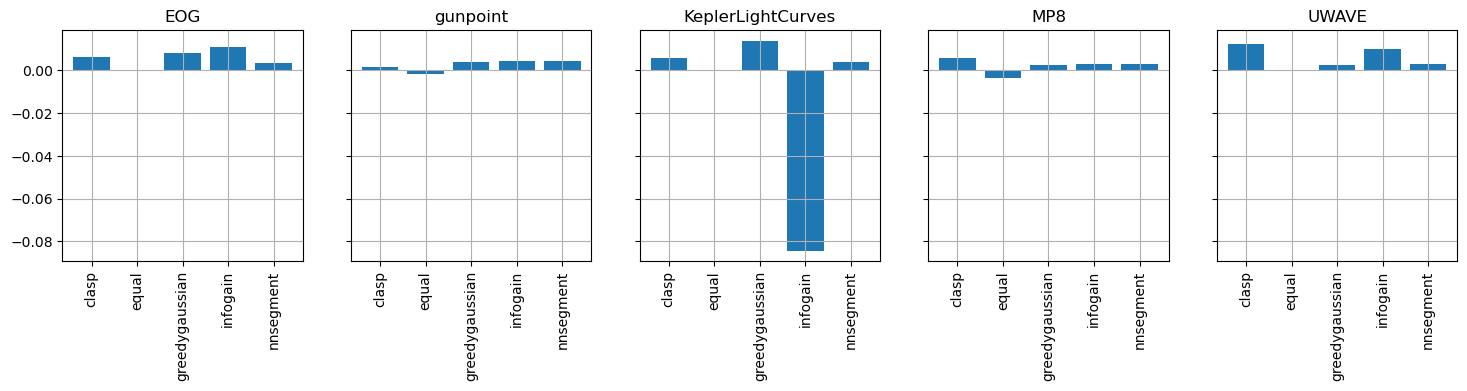

In [70]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="F_score") # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask].groupby(["Dataset", "Segmentation", "Normalization"]).agg({'Result': "mean"}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (18,3), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Normalization", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Normalization"]=="default")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y1 = df4["Result"].values

    mask = (df3["Normalization"]=="normalized")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    y2 = df5["Result"].values

    ax[i].bar(x, y2-y1)
    ax[i].grid()
    ax[i].tick_params("x", rotation=90)

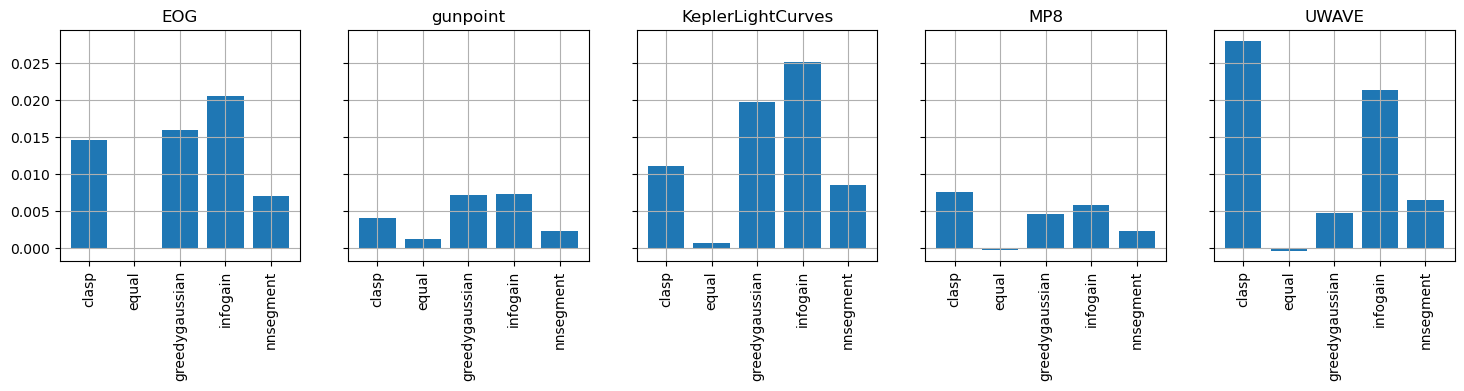

In [71]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=='AUCSE_top') # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask].groupby(["Dataset", "Segmentation", "Normalization"]).agg({'Result': "mean"}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (18,3), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Normalization", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Normalization"]=="default")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y1 = df4["Result"].values

    mask = (df3["Normalization"]=="normalized")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    y2 = df5["Result"].values

    ax[i].bar(x, y2-y1)
    ax[i].grid()
    ax[i].tick_params("x", rotation=90)

In [22]:
0/0

ZeroDivisionError: division by zero

### F_score
#### local_gaussian vs global_gaussian

### Per Column values correlations

In [44]:
import seaborn as sns

In [45]:
palette = sns.color_palette("tab10") # hls

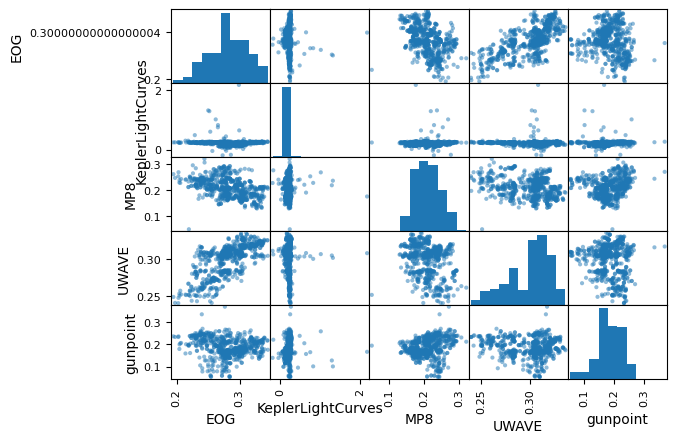

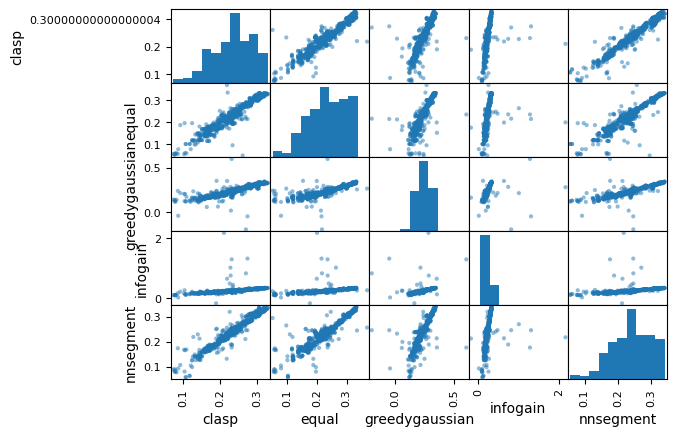

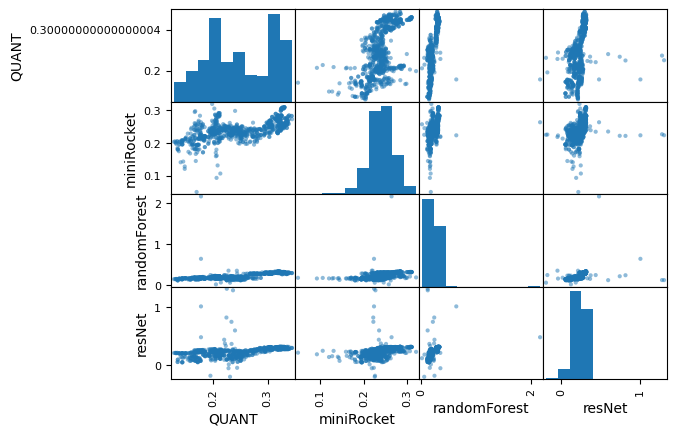

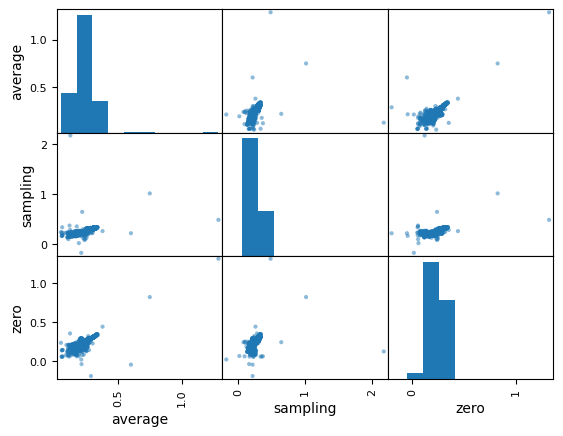

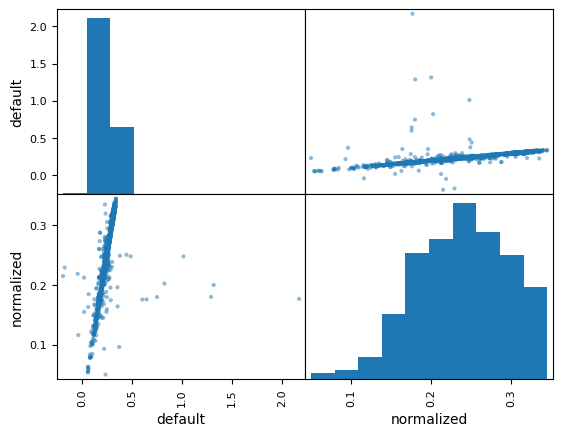

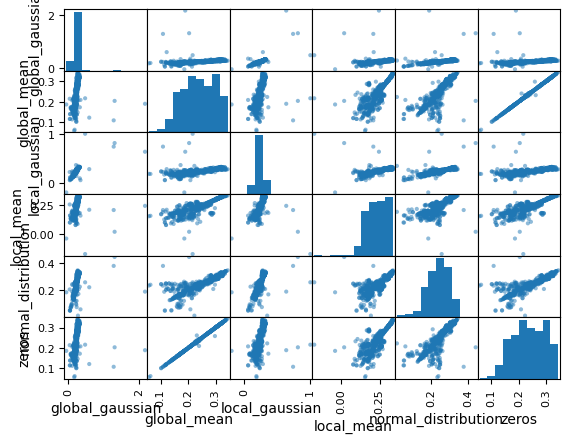

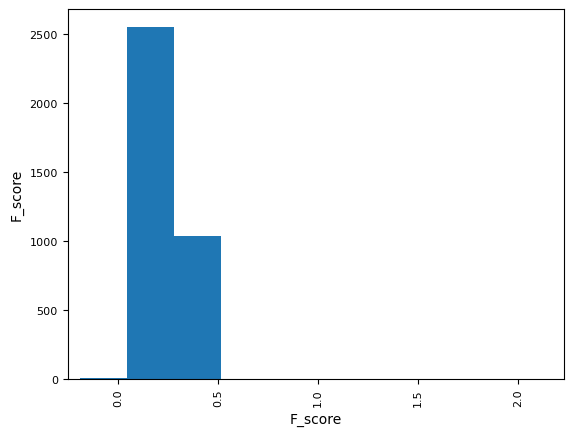

In [202]:
metric_name = 'F_score'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask] # , ['Perturb', "Result"]

#fig, ax = plt.subplots(1, len(columns_wo_result), figsize = (25,4), sharex=False, sharey=True)

for i, column_name in enumerate(columns_wo_result):
    new_index = columns_wo_result[:]
    new_index.remove(column_name)
    df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
    pd.plotting.scatter_matrix(df3)
    #ax[i].scattermatrix(df3.index, df3)
    # ax[i].set_xticklabels(df3.index, rotation=90)
    # ax[i].set_title(column_name)

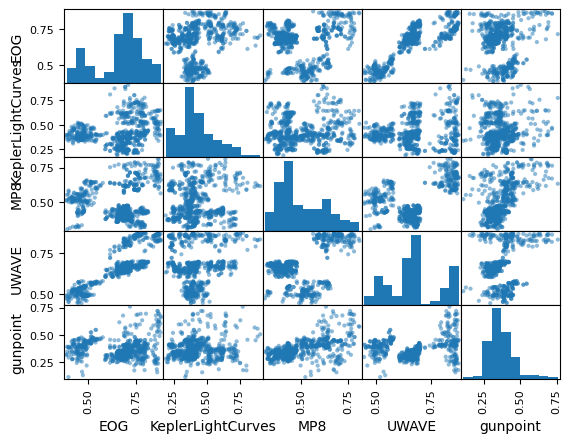

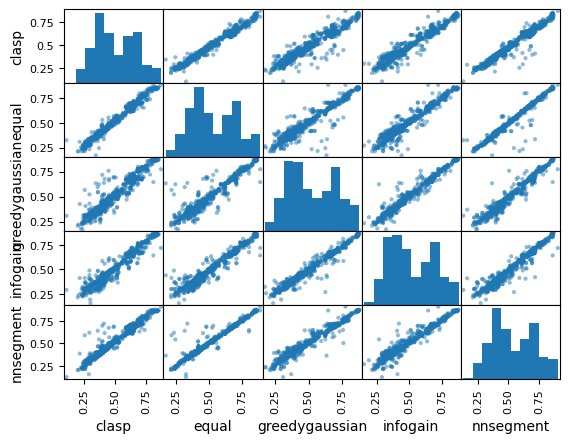

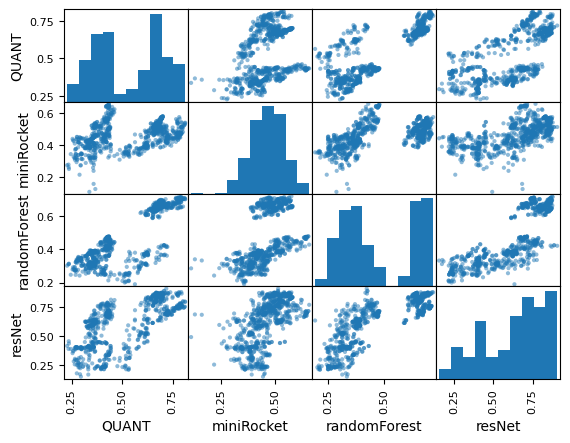

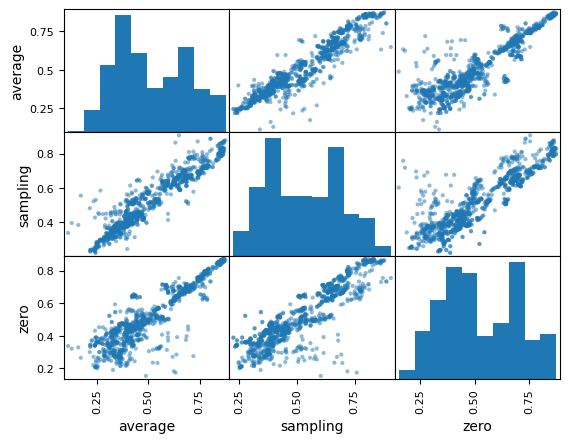

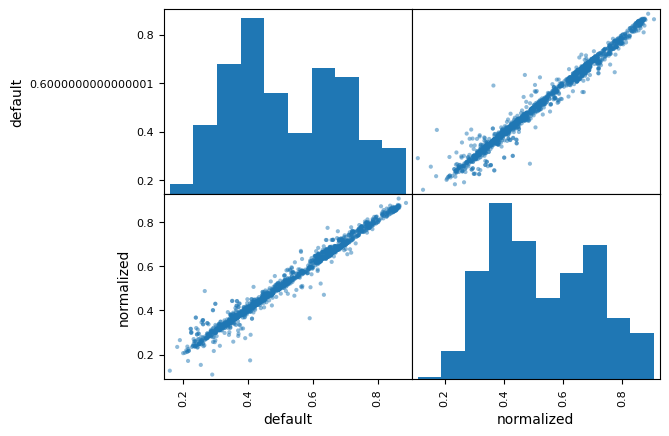

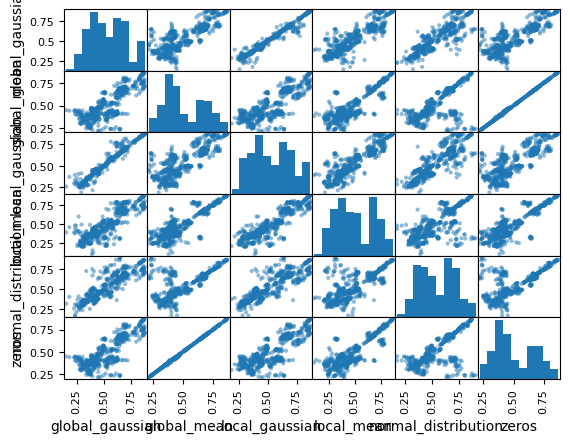

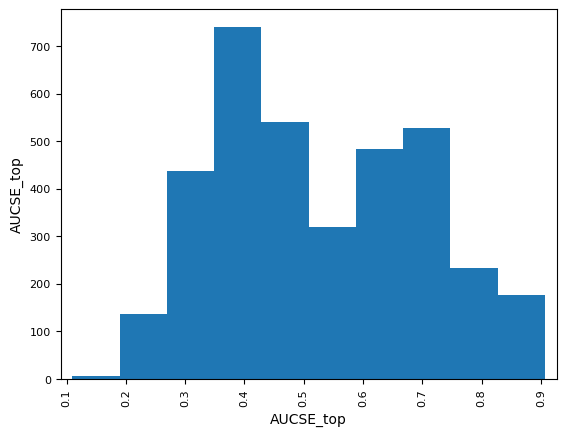

In [203]:
metric_name = 'AUCSE_top'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask] # , ['Perturb', "Result"]

#fig, ax = plt.subplots(1, len(columns_wo_result), figsize = (25,4), sharex=False, sharey=True)

for i, column_name in enumerate(columns_wo_result):
    new_index = columns_wo_result[:]
    new_index.remove(column_name)
    df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
    pd.plotting.scatter_matrix(df3)
    #ax[i].scattermatrix(df3.index, df3)
    # ax[i].set_xticklabels(df3.index, rotation=90)
    # ax[i].set_title(column_name)

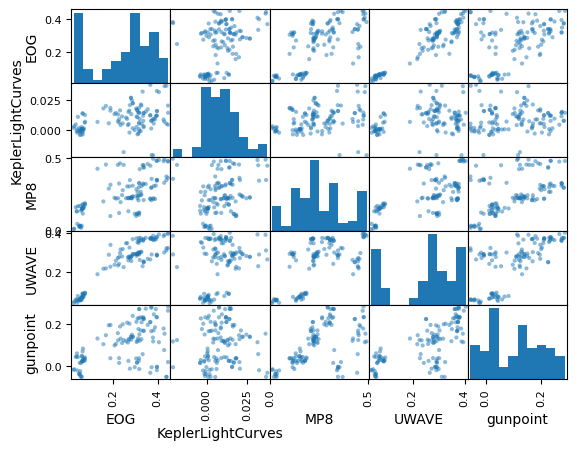

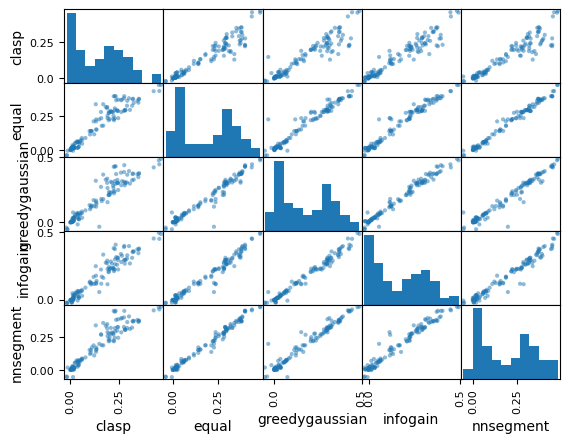

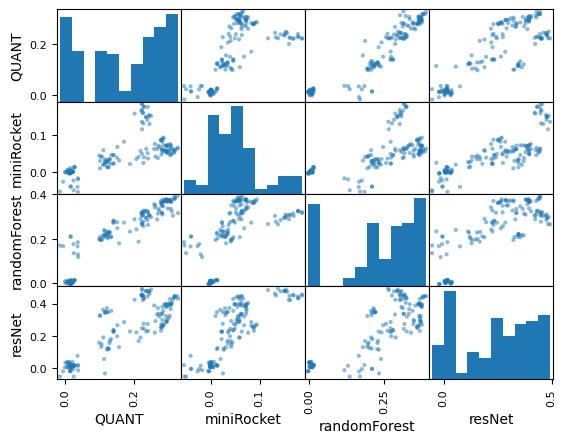

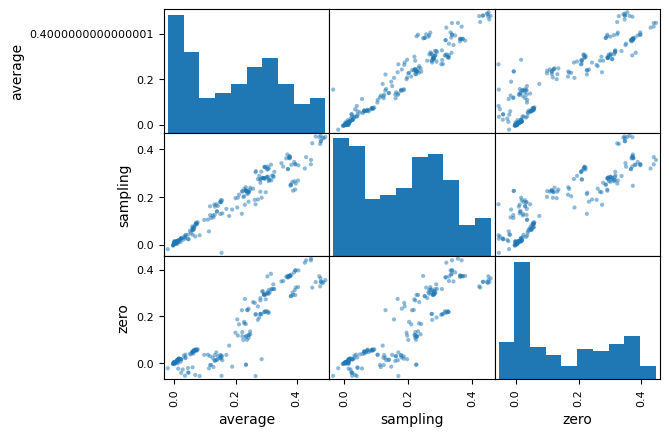

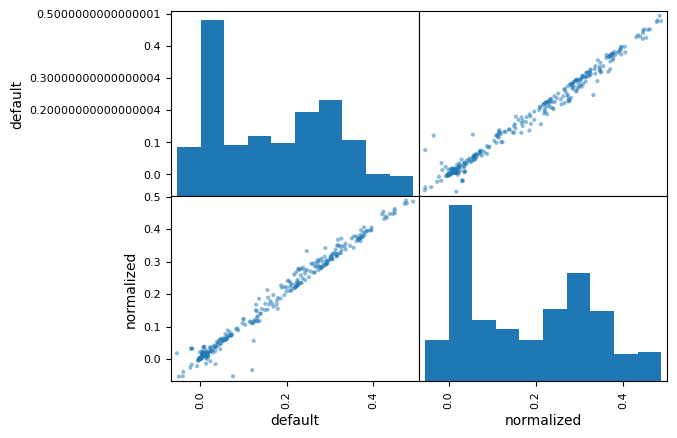

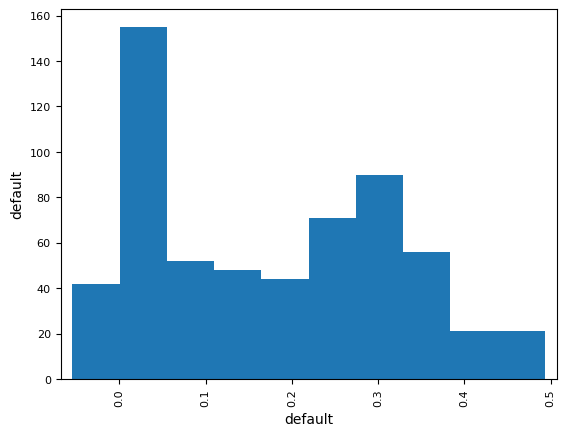

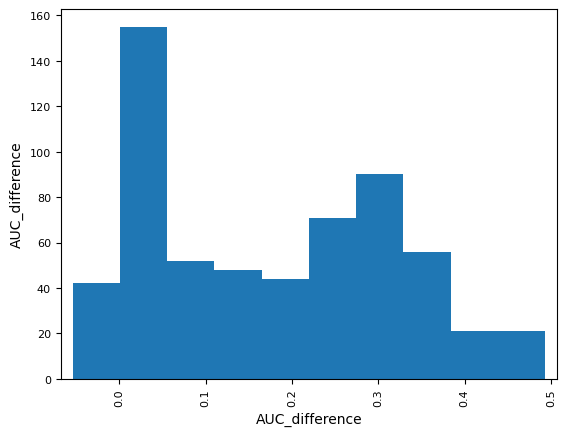

In [204]:
metric_name = 'AUC_difference'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask] # , ['Perturb', "Result"]

#fig, ax = plt.subplots(1, len(columns_wo_result), figsize = (25,4), sharex=False, sharey=True)

for i, column_name in enumerate(columns_wo_result):
    new_index = columns_wo_result[:]
    new_index.remove(column_name)
    df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
    pd.plotting.scatter_matrix(df3)
    #ax[i].scattermatrix(df3.index, df3)
    # ax[i].set_xticklabels(df3.index, rotation=90)
    # ax[i].set_title(column_name)

In [49]:
df2 = df.unstack(["Background"])
df2.columns = df2.columns.droplevel(0)
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

Background,average,sampling,zero
Background,,,
average,1.00,0.90,0.90
sampling,0.90,1.00,0.85
zero,0.90,0.85,1.00


c:\Users\Nikos\miniconda3\envs\segment_shap\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Axes: xlabel='average', ylabel='sampling'>

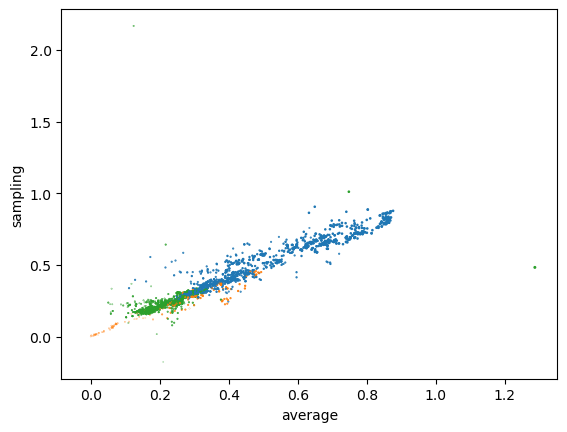

In [50]:
color_index = np.unique(df2.index.get_level_values(-1), return_inverse=True)[1]
colors = np.array(palette)[color_index]
df2.plot.scatter(*df2.columns.values, c=colors)

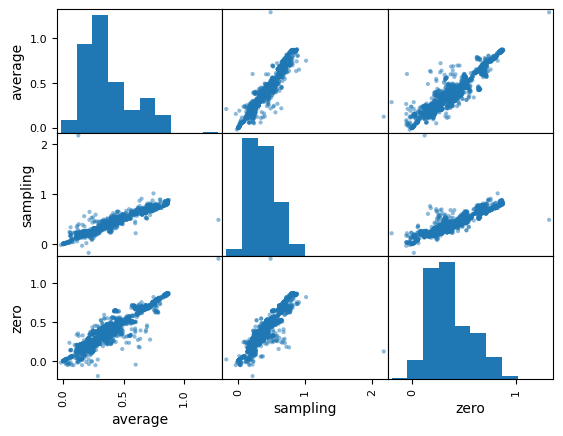

In [51]:
pd.plotting.scatter_matrix(df2)
pass

In [52]:
df2 = df.unstack(["Segmentation"])
df2.columns = df2.columns.droplevel(0)
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

Segmentation,clasp,equal,greedygaussian,infogain,nnsegment
Segmentation,,,,,
clasp,1.00,0.98,0.94,0.85,0.97
equal,0.98,1.00,0.95,0.85,0.97
greedygaussian,0.94,0.95,1.00,0.86,0.97
infogain,0.85,0.85,0.86,1.00,0.85
nnsegment,0.97,0.97,0.97,0.85,1.00


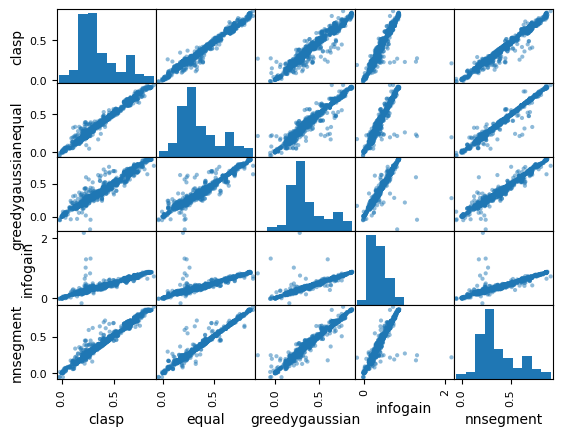

In [53]:
pd.plotting.scatter_matrix(df2)
pass

In [54]:
0/0

ZeroDivisionError: division by zero

In [ ]:
df2

Metric                                                              AUCSE_top  \
Perturb                                                   normal_distribution   
Dataset  Segmentation ML model   Background Normalization                       
UWAVE    clasp        miniRocket average    default                  0.538427   
                                            normalized               0.534783   
                                 sampling   default                  0.612026   
                                            normalized               0.669789   
                                 zero       default                  0.539440   
...                                                                       ...   
gunpoint nnsegment    resNet     average    normalized               0.493474   
                                 sampling   default                  0.487042   
                                            normalized               0.493356   
                                 zero       default                  0.485419   
                                            normalized               0.490639   

Metric                                                                F_score  \
Perturb                                                   normal_distribution   
Dataset  Segmentation ML model   Background Normalization                       
UWAVE    clasp        miniRocket average    default                  0.259149   
                                            normalized               0.257324   
                                 sampling   default                  0.299846   
                                            normalized               0.322807   
                                 zero       default                  0.261899   
...                                                                       ...   
gunpoint nnsegment    resNet     average    normalized               0.197166   
                                 sampling   default                  0.206901   
                                            normalized               0.210886   
                                 zero       default                  0.198961   
                                            normalized               0.202388   

Metric                                                    AUCSE_top   F_score  \
Perturb                                                       zeros     zeros   
Dataset  Segmentation ML model   Background Normalization                       
UWAVE    clasp        miniRocket average    default        0.660287  0.288037   
                                            normalized     0.678078  0.292222   
                                 sampling   default        0.648093  0.283887   
                                            normalized     0.673980  0.292719   
                                 zero       default        0.720051  0.297354   
...                                                             ...       ...   
gunpoint nnsegment    resNet     average    normalized     0.615215  0.213033   
                                 sampling   default        0.504398  0.232070   
                                            normalized     0.528187  0.232014   
                                 zero       default        0.753633  0.254793   
                                            normalized     0.764739  0.259414   

Metric                                                      AUCSE_top  \
Perturb                                                   global_mean   
Dataset  Segmentation ML model   Background Normalization               
UWAVE    clasp        miniRocket average    default          0.659023   
                                            normalized       0.676209   
                                 sampling   default          0.648215   
                                            normalized       0.672996   
                                 zero       default          0.720051   
...        

In [ ]:
vals = df2.groupby(level=("Dataset")).mean().values

In [ ]:
vals

array([[0.6855324 , 0.28057011, 0.71828536, 0.2958138 , 0.71828022,
        0.29582941, 0.70924087, 0.29813861, 0.68613147, 0.28058454,
        0.68468829, 0.28105192],
       [0.36098013, 0.16558069, 0.3586987 , 0.16028276, 0.3586987 ,
        0.16028276, 0.3566728 , 0.1612429 , 0.36523113, 0.13353505,
        0.34681318, 0.15673057]])

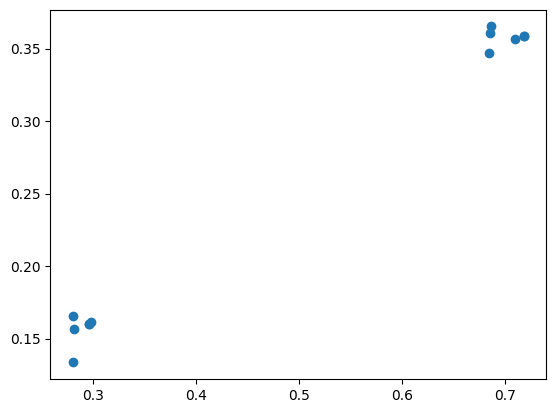

In [ ]:
plt.scatter(*vals)

In [ ]:
df2["F_score"].groupby(level=("Dataset", 'Segmentation')).mean()

Perturb                  normal_distribution     zeros  global_mean  \
Dataset  Segmentation                                                 
UWAVE    clasp                      0.274687  0.288673     0.288690   
         equal                      0.282539  0.299336     0.299356   
         greedygaussian             0.283751  0.298759     0.298770   
         infogain                   0.280672  0.293619     0.293635   
         nnsegment                  0.281202  0.298683     0.298696   
gunpoint clasp                      0.161752  0.160789     0.160789   
         equal                      0.148711  0.153905     0.153905   
         greedygaussian             0.171350  0.163258     0.163258   
         infogain                   0.176317  0.156651     0.156651   
         nnsegment                  0.169772  0.166811     0.166811   

Perturb                  local_mean  global_gaussian  local_gaussian  
Dataset  Segmentation                                                 
UWAVE    clasp             0.290478         0.274625        0.275029  
         equal             0.302188         0.282444        0.283118  
         greedygaussian    0.301157         0.283842        0.284356  
         infogain          0.295905         0.280646        0.281294  
         nnsegment         0.300965         0.281365        0.281462  
gunpoint clasp             0.152200         0.161012        0.145715  
         equal             0.150435         0.148643        0.143215  
         greedygaussian    0.166813         0.171361        0.159863  
         infogain          0.165410         0.016511        0.173378  
         nnsegment         0.171356         0.170148        0.161482

In [ ]:
df2.groupby(level=("Dataset")).mean()

Perturb  normal_distribution               zeros           global_mean  \
Metric             AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
Dataset                                                                  
UWAVE               0.685532  0.280570  0.718285  0.295814    0.718280   
gunpoint            0.360980  0.165581  0.358699  0.160283    0.358699   

Perturb            local_mean           global_gaussian            \
Metric     F_score  AUCSE_top   F_score       AUCSE_top   F_score   
Dataset                                                             
UWAVE     0.295829   0.709241  0.298139        0.686131  0.280585   
gunpoint  0.160283   0.356673  0.161243        0.365231  0.133535   

Perturb  local_gaussian            
Metric        AUCSE_top   F_score  
Dataset                            
UWAVE          0.684688  0.281052  
gunpoint       0.346813  0.156731

In [ ]:
df2.groupby(level=('Segmentation')).mean()

Perturb        normal_distribution               zeros           global_mean  \
Metric                   AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
Segmentation                                                                   
clasp                     0.503013  0.218219  0.521946  0.224731    0.521945   
equal                     0.533172  0.215625  0.550048  0.226620    0.550051   
greedygaussian            0.535196  0.227551  0.542901  0.231008    0.542892   
infogain                  0.516158  0.228495  0.529818  0.225135    0.529817   
nnsegment                 0.528743  0.225487  0.547747  0.232747    0.547743   

Perturb                  local_mean           global_gaussian            \
Metric           F_score  AUCSE_top   F_score       AUCSE_top   F_score   
Segmentation                                                              
clasp           0.224739   0.505324  0.221339        0.506134  0.217819   
equal           0.226631   0.540018  0.226311        0.533175  0.215544   
greedygaussian  0.231014   0.541474  0.233985        0.540443  0.227602   
infogain        0.225143   0.528180  0.230657        0.517239  0.148578   
nnsegment       0.232754   0.549789  0.236161        0.531415  0.225757   

Perturb        local_gaussian            
Metric              AUCSE_top   F_score  
Segmentation                             
clasp                0.495415  0.210372  
equal                0.524497  0.213166  
greedygaussian       0.520534  0.222110  
infogain             0.513947  0.227336  
nnsegment            0.524361  0.221472

In [ ]:
df2.groupby(level=("ML model")).mean()

Perturb      normal_distribution               zeros           global_mean  \
Metric                 AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
ML model                                                                     
miniRocket              0.471642  0.209057  0.476258  0.207937    0.476250   
randomForest            0.484716  0.228739  0.509178  0.241806    0.509178   
resNet                  0.613411  0.231430  0.630040  0.234402    0.630040   

Perturb                local_mean           global_gaussian            \
Metric         F_score  AUCSE_top   F_score       AUCSE_top   F_score   
ML model                                                                
miniRocket    0.207960   0.465192  0.209240        0.472131  0.161151   
randomForest  0.241806   0.491761  0.236569        0.483761  0.228632   
resNet        0.234402   0.641918  0.243263        0.621152  0.231396   

Perturb      local_gaussian            
Metric            AUCSE_top   F_score  
ML model                               
miniRocket         0.443839  0.197479  
randomForest       0.469916  0.223540  
resNet             0.633496  0.235655

In [ ]:
df2.groupby(level=("Background")).mean()

Perturb    normal_distribution               zeros           global_mean  \
Metric               AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
Background                                                                 
average               0.475765  0.198182  0.498045  0.203332    0.498053   
sampling              0.545851  0.245845  0.516964  0.237249    0.516956   
zero                  0.548153  0.225199  0.600467  0.243564    0.600460   

Perturb              local_mean           global_gaussian            \
Metric       F_score  AUCSE_top   F_score       AUCSE_top   F_score   
Background                                                            
average     0.203341   0.592623  0.240304        0.481797  0.150370   
sampling    0.237254   0.520034  0.243762        0.548044  0.246446   
zero        0.243572   0.486214  0.205006        0.547202  0.224364   

Perturb    local_gaussian            
Metric          AUCSE_top   F_score  
Background                           
average          0.490520  0.203760  
sampling         0.546220  0.247256  
zero             0.510512  0.205657